In [5]:
# custom packages
from LLT import preprocessing as pp
from LLT import linear_law as ll

# standard packages
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np

# Prepare the datasets

## Load the data

In [6]:
# train file name
train_file = "ecg_train.mat"

# test file name
test_file = "ecg_test.mat"

# loading the raw train data
train_data, train_data_labels = pp.Load_VPNet_data(train_file)

# Loading the raw test data
test_data, test_data_labels = pp.Load_VPNet_data(test_file)

## Create, train, validation, test

In [7]:
train_samples, validation_samples, train_labels, validation_labels = train_test_split(train_data, train_data_labels, 
                                                                          test_size=0.6, 
                                                                          random_state=0, 
                                                                          stratify= train_data_labels)

In [8]:
test_samples = test_data
test_labels = test_data_labels

## Resample

In [9]:
train_samples = pp.Resample(train_samples, 360, 250)
test_samples = pp.Resample(test_samples, 360, 250)
validation_samples = pp.Resample(validation_samples, 360, 250)

## Noise filtering

In [10]:
train_samples = pp.denoise(train_samples)
test_samples = pp.denoise(test_samples)
validation_samples = pp.denoise(validation_samples)

# Feature generation

## Create peak dataset

In [11]:
# these peak search proterties are used everywhere in this document
peak_settings = {'normalize':"max", 'peak_height':0.99, 'window':[13, 16]} 

In [12]:
train_peak_data = pp.Peak_data(train_samples, **peak_settings)

In [13]:
train_peak_samples, train_peak_labels = train_peak_data.generate_peak_dataset(train_labels)

## Train the linear model on the normal beats

### Select the normal peaks

In [14]:
normal_train_peak_samples = train_peak_samples[np.where(train_peak_labels == 1)[0]]

### Train a linear law on the normal peaks

In [15]:
llaw = ll.linear_model(normal_train_peak_samples, 10)

In [16]:
llaw.fit()

In [17]:
# --- Check the linear law ---
llaw.linear_law

array([-0.00456718,  0.03553229, -0.13091927,  0.30169969, -0.48289173,
        0.56207008, -0.48223705,  0.30096837, -0.13052494,  0.03542311,
       -0.00455481])

In [18]:
# Check how well it describes the dataset ---
llaw.score

1.6878114431588527e-07

In [19]:
# --- Check the eigenvalues ---
eivals = np.sort(llaw.PCA_eigenvalues)[::-1]

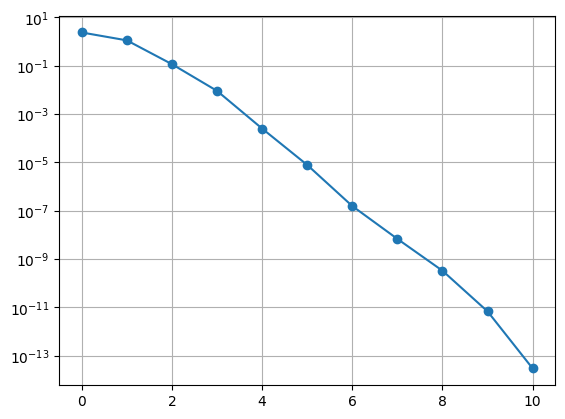

In [21]:
plt.plot(eivals,"-o")
plt.grid()
plt.yscale("log")

## Generate features to train the classificator

In [22]:
tf_train_peak_samples = llaw.feature_transform(train_peak_samples)

# Train A support vector machine on the generated features and test the model

## SVM fit

In [23]:
from sklearn import svm
clf = svm.SVC(kernel='rbf',random_state=0, tol=1e-4)
clf.fit(tf_train_peak_samples, train_peak_labels)

SVC(random_state=0, tol=0.0001)

## Make predictions

In [19]:
predictions_validation = pp.general_predict(validation_samples, llaw, clf, **peak_settings)
predictions_test = pp.general_predict(test_samples, llaw, clf, **peak_settings)

## Validation set results

In [20]:
CM = confusion_matrix(validation_labels, predictions_validation)
print(CM  )
pp.performance_metrics(CM)

[[2462   94]
 [ 163 2393]]
                 Total accuracy :  0.9497
- - - - - - - - - - - - - - - - - - - - - 
             Normal sensitivity :  0.9632
            Ectopic sensitivity :  0.9362
 Normal positive predictibility :  0.9379
Ectopic positive predictibility :  0.9622


{'Total_accuracy': 0.9497261345852895,
 'Normal_sensitivity': 0.9632237871674492,
 'Ectopic_sensitivity ': 0.9362284820031299,
 'Normal_positive_predictibility': 0.9379047619047619,
 'Ectopic_positive_predictibility': 0.9622034579815039}

## Test set results

In [21]:
CM = confusion_matrix(test_labels, predictions_test)
print(CM  )
pp.performance_metrics(CM)

[[3039  181]
 [ 186 3034]]
                 Total accuracy :  0.9430
- - - - - - - - - - - - - - - - - - - - - 
             Normal sensitivity :  0.9438
            Ectopic sensitivity :  0.9422
 Normal positive predictibility :  0.9423
Ectopic positive predictibility :  0.9437


{'Total_accuracy': 0.9430124223602484,
 'Normal_sensitivity': 0.9437888198757765,
 'Ectopic_sensitivity ': 0.9422360248447205,
 'Normal_positive_predictibility': 0.9423255813953488,
 'Ectopic_positive_predictibility': 0.943701399688958}